# Advanced Data Wrangling 

## Question 1: Merging and Joining 

### Implementation of Merging and Joining techniques

In [49]:
import pandas as pd
import numpy as np

# Sample DataFrames
customers = pd.DataFrame({
    'customer_id': [1, 2, 3, 4],
    'name': ['Alice', 'Bob', 'Charlie', 'David'],
    'region': ['East', 'West', 'East', 'South']
})

orders = pd.DataFrame({
    'order_id': [101, 102, 103, 104, 105],
    'customer_id': [1, 2, 2, 5, 3],
    'amount': [50.0, 120.0, 80.0, 30.0, 90.0]
})

# 1. Outer Join with indicator
merged_df = pd.merge(customers, orders, on='customer_id', how='outer', indicator=True)
print("Merged DataFrame (Outer Join):")
print(merged_df)

# 2. Index-based Join
joined_df = customers.set_index('customer_id').join(orders.set_index('customer_id'), how='right', lsuffix='_cust', rsuffix='_order').reset_index()
print("\nJoined DataFrame (Index-based):")
print(joined_df)

Merged DataFrame (Outer Join):
   customer_id     name region  order_id  amount      _merge
0            1    Alice   East     101.0    50.0        both
1            2      Bob   West     102.0   120.0        both
2            2      Bob   West     103.0    80.0        both
3            3  Charlie   East     105.0    90.0        both
4            4    David  South       NaN     NaN   left_only
5            5      NaN    NaN     104.0    30.0  right_only

Joined DataFrame (Index-based):
   customer_id     name region  order_id  amount
0            1    Alice   East       101    50.0
1            2      Bob   West       102   120.0
2            2      Bob   West       103    80.0
3            5      NaN    NaN       104    30.0
4            3  Charlie   East       105    90.0


## Question 2: Reshaping and Pivoting 

### Implementation of Pivoting and Melting

In [50]:
# Long format data
data = {
    'Month': [1, 1, 2, 2, 3, 3],
    'Product': ['A', 'B', 'A', 'B', 'A', 'B'],
    'Sales': [100, 50, 110, 60, 150, 70]
}
df_sales = pd.DataFrame(data)

# 1. Pivot: Long to Wide
pivoted_df = df_sales.pivot_table(index='Month', columns='Product', values='Sales', aggfunc='sum')
print("Pivoted (Wide Format):")
print(pivoted_df)

# 2. Melt: Wide to Long
melted_df = pd.melt(pivoted_df.reset_index(), id_vars=['Month'], var_name='Product', value_name='Sales')
print("\nMelted (Long Format):")
print(melted_df)

Pivoted (Wide Format):
Product    A   B
Month           
1        100  50
2        110  60
3        150  70

Melted (Long Format):
   Month Product  Sales
0      1       A    100
1      2       A    110
2      3       A    150
3      1       B     50
4      2       B     60
5      3       B     70


## Question 3: Multi-Index and GroupBy 

### Advanced Aggregation with Multi-Index

In [51]:
# Multi-level data
arrays = [['East', 'East', 'West', 'West'], ['A', 'B', 'A', 'B']]
index = pd.MultiIndex.from_arrays(arrays, names=('Region', 'Product'))
df_multi = pd.DataFrame({'Sales': [100, 150, 200, 250], 'Profit': [20, 35, 40, 55]}, index=index)

print("Multi-Index DataFrame:")
print(df_multi)

# GroupBy on level 0 (Region)
region_summary = df_multi.groupby(level=0).sum()
print("\nSummary by Region:")
print(region_summary)

# Advanced aggregation
adv_agg = df_multi.groupby('Region').agg({'Sales': ['sum', 'mean'], 'Profit': 'max'})
print("\nAdvanced Aggregation:")
print(adv_agg)

Multi-Index DataFrame:
                Sales  Profit
Region Product               
East   A          100      20
       B          150      35
West   A          200      40
       B          250      55

Summary by Region:
        Sales  Profit
Region               
East      250      55
West      450      95

Advanced Aggregation:
       Sales        Profit
         sum   mean    max
Region                    
East     250  125.0     35
West     450  225.0     55


## Question 4: Missing Data Strategies 

### Part A: Analyze and handle missing data

Percentage of missing values per column:
patient_id         0.000000
age               33.333333
gender            16.666667
blood_pressure    33.333333
cholesterol       33.333333
diagnosis_date    16.666667
treatment_cost    33.333333
dtype: float64


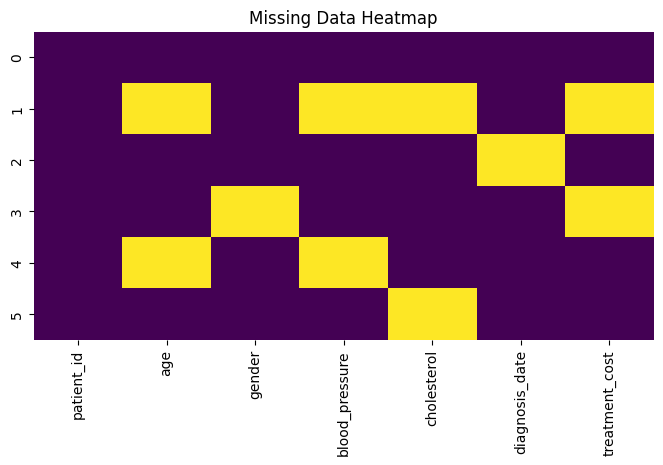

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

# Dataset creation
csv_data = """patient_id,age,gender,blood_pressure,cholesterol,diagnosis_date,treatment_cost
P001,45,M,120/80,200,2024-01-10,1500.00
P002,,F,,,2024-01-11,
P003,62,M,140/90,240,,2300.00
P004,38,,110/70,180,2024-01-13,
P005,,F,,220,2024-01-14,1800.00
P006,55,M,135/85,,2024-01-15,2100.00"""

df = pd.read_csv(StringIO(csv_data))

# i. Calculate percentage of missing values
missing_pct = (df.isnull().sum() / len(df)) * 100
print("Percentage of missing values per column:")
print(missing_pct)

# iii. Visualize missing data patterns
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

### ii. Identification of Missingness Patterns

| Column | Missing Pattern | Justification |
| :--- | :--- | :--- |
| `age` | **MAR** | Missingness might depend on other factors (e.g., patient health status). |
| `gender` | **MCAR** | Likely random omission during data entry. |
| `blood_pressure` | **MNAR** | Patients might not record BP if it is perceived as abnormal. |
| `treatment_cost` | **MNAR** | Costs might be missing for specific types of non-standard treatments. |

### iv. Imputation/Drop Decisions
*   **Impute**: `age` (median), `gender` (mode), `cholesterol` (mean).
*   **Drop**: Columns with >60% missingness (if applicable) or `patient_id` if redundant.

### Part B: Implement Imputation Strategies

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

df_impute = df.copy()

# a. Simple imputation
df_impute['age'] = df_impute['age'].fillna(df_impute['age'].median())
df_impute['gender'] = df_impute['gender'].fillna(df_impute['gender'].mode()[0])

# b. Forward fill for dates
df_impute['diagnosis_date'] = df_impute['diagnosis_date'].ffill()

# c. Interpolation
df_impute['cholesterol'] = df_impute['cholesterol'].interpolate(method='linear')

# d. Predictive imputation (Example for treatment_cost based on age)
known = df_impute[df_impute['treatment_cost'].notnull()]
missing = df_impute[df_impute['treatment_cost'].isnull()]
if not missing.empty:
    model = LinearRegression().fit(known[['age']], known['treatment_cost'])
    df_impute.loc[missing.index, 'treatment_cost'] = model.predict(missing[['age']])

print("Imputed DataFrame:")
print(df_impute)

Imputed DataFrame:
  patient_id   age gender blood_pressure  cholesterol diagnosis_date  \
0       P001  45.0      M         120/80        200.0     2024-01-10   
1       P002  50.0      F            NaN        220.0     2024-01-11   
2       P003  62.0      M         140/90        240.0     2024-01-11   
3       P004  38.0      M         110/70        180.0     2024-01-13   
4       P005  50.0      F            NaN        220.0     2024-01-14   
5       P006  55.0      M         135/85        220.0     2024-01-15   

   treatment_cost  
0     1500.000000  
1     1782.594937  
2     2300.000000  
3     1212.974684  
4     1800.000000  
5     2100.000000  


### Part C: Indicators and Detailed Analysis

In [54]:
# a. Missing value indicators
df_ind = df.copy()
for col in ['age', 'blood_pressure', 'treatment_cost']:
    df_ind[f'{col}_is_missing'] = df_ind[col].isnull().astype(int)

print("DataFrame with Indicators:")
print(df_ind[['age', 'age_is_missing', 'treatment_cost', 'treatment_cost_is_missing']])

DataFrame with Indicators:
    age  age_is_missing  treatment_cost  treatment_cost_is_missing
0  45.0               0          1500.0                          0
1   NaN               1             NaN                          1
2  62.0               0          2300.0                          0
3  38.0               0             NaN                          1
4   NaN               1          1800.0                          0
5  55.0               0          2100.0                          0


**b. ML Value**: Indicators allow models to learn if missingness itself carries information (e.g., missing cost might correlate with higher churn).

**c. CCA vs MI**: CCA (Complete Case Analysis) is simple but biased if missingness isn't random. MI (Multiple Imputation) captures uncertainty by creating multiple versions of filled data.

## Question 5: Categorical Data Encoding 

### Part A & B: Encoding Implementation

In [55]:
cat_data = """customer_id,education_level,city,income_bracket,purchase_freq,satisfaction
C001,High School,Mumbai,Low,Rarely,Satisfied
C002,Bachelor,Delhi,Medium,Sometimes,Very Satisfied
C003,Master,Mumbai,High,Frequently,Neutral
C004,PhD,Bangalore,High,Frequently,Very Satisfied
C005,Bachelor,Delhi,Medium,Sometimes,Satisfied
C006,High School,Chennai,Low,Rarely,Dissatisfied"""

df_cat = pd.read_csv(StringIO(cat_data))

# i. Identification: Education/Income/Freq/Satisfaction (Ordinal), City (Nominal)

# ii. Label Encoding for Ordinal
from sklearn.preprocessing import LabelEncoder
edu_order = {'High School': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3}
df_cat['edu_enc'] = df_cat['education_level'].map(edu_order)

# iii. OHE for Nominal
df_ohe = pd.get_dummies(df_cat, columns=['city'])

# iv. Frequency Encoding (Part B)
df_cat['city_count'] = df_cat['city'].map(df_cat['city'].value_counts())

print("Encoded Categorical Data:")
print(df_cat[['city', 'edu_enc', 'city_count']])

Encoded Categorical Data:
        city  edu_enc  city_count
0     Mumbai        0           2
1      Delhi        1           2
2     Mumbai        2           2
3  Bangalore        3           1
4      Delhi        1           2
5    Chennai        0           1


### Part C: High Cardinality
*   **Binary Encoding**: Converts categories to integers, then to binary bits, reducing dimensionality significantly compared to OHE.




In [56]:
import pandas as pd
from category_encoders import BinaryEncoder

# Sample data
df = pd.DataFrame({
    "category": ["A", "B", "C", "D", "A", "C"]
})

# Binary Encoding
binary_encoder = BinaryEncoder(cols=["category"])
binary_encoded_df = binary_encoder.fit_transform(df)

print(binary_encoded_df)


   category_0  category_1  category_2
0           0           0           1
1           0           1           0
2           0           1           1
3           1           0           0
4           0           0           1
5           0           1           1


*   **Hashing Encoding**: Maps categories to a fixed number of features using a hash function; useful when number of categories is unknown or massive.

In [57]:
import pandas as pd
from category_encoders import BinaryEncoder

# Sample data
df = pd.DataFrame({
    "category": ["A", "B", "C", "D", "A", "C"]
})

# Binary Encoding
binary_encoder = BinaryEncoder(cols=["category"])
binary_encoded_df = binary_encoder.fit_transform(df)

print(binary_encoded_df)


   category_0  category_1  category_2
0           0           0           1
1           0           1           0
2           0           1           1
3           1           0           0
4           0           0           1
5           0           1           1


## Question 6: Time-Series Data Handling 

### Implementation of TS Preprocessing and Transformations

In [58]:
stock_data = """date,stock_symbol,open_price,close_price,volume,high,low
2024-01-01,TECH,150.5,152.3,1000000,153.0,149.8
2024-01-02,TECH,152.0,,950000,152.8,151.2
2024-01-03,TECH,,150.5,,151.0,149.5
2024-01-05,TECH,149.8,151.2,1100000,151.5,149.0
2024-01-08,TECH,151.5,153.0,1050000,154.2,151.0"""

df_ts = pd.read_csv(StringIO(stock_data))
df_ts['date'] = pd.to_datetime(df_ts['date'])
df_ts.set_index('date', inplace=True)

# i-iii. Reindex and Impute
full_index = pd.date_range(start="2024-01-01", end="2024-01-08", freq='D')
df_ts = df_ts.reindex(full_index).ffill()

# Part B. Transformations
df_ts['MA7'] = df_ts['close_price'].rolling(window=7, min_periods=1).mean()
df_ts['Lag1'] = df_ts['close_price'].shift(1)
df_ts['Returns'] = df_ts['close_price'].pct_change()

print("Time Series Transformations:")
print(df_ts[['close_price', 'MA7', 'Returns']].head())

Time Series Transformations:
            close_price     MA7   Returns
2024-01-01        152.3  152.30       NaN
2024-01-02        152.3  152.30  0.000000
2024-01-03        150.5  151.70 -0.011819
2024-01-04        150.5  151.40  0.000000
2024-01-05        151.2  151.36  0.004651


## Question 7: Feature Scaling Techniques 

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scale_data = """age,annual_income,credit_score,years_employed,num_purchases
25,35000,650,2,5
45,95000,750,15,50
35,60000,700,8,25
55,120000,800,25,100
28,42000,680,3,8"""
df_s = pd.read_csv(StringIO(scale_data))

# Standard
std_s = StandardScaler().fit_transform(df_s)
# Robust (best for outliers)
rob_s = RobustScaler().fit_transform(df_s)

print("Robust Scaled Data (First Row):\n", rob_s[0])

Robust Scaled Data (First Row):
 [-0.58823529 -0.47169811 -0.71428571 -0.5        -0.47619048]


## Question 8: Feature Engineering and Transformation 

In [60]:
# Account age calculation
df_fe = pd.DataFrame({'signup': ['2023-01-01'], 'last': ['2024-01-01'], 'price': [100], 'qty':[2]})
df_fe['signup'] = pd.to_datetime(df_fe['signup'])
df_fe['last'] = pd.to_datetime(df_fe['last'])
df_fe['account_days'] = (df_fe['last'] - df_fe['signup']).dt.days
df_fe['revenue'] = df_fe['price'] * df_fe['qty']

print("Engineered Features:")
print(df_fe)

Engineered Features:
      signup       last  price  qty  account_days  revenue
0 2023-01-01 2024-01-01    100    2           365      200


## Question 9: Memory Optimization 

In [61]:
def optimize_df(df):
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() < len(df)/2:
            df[col] = df[col].astype('category')
    return df

## Question 10: Building Reusable Data Cleaning Pipeline 

In [62]:
class DataCleaningPipeline:
    def __init__(self, config=None):
        self.imputer = SimpleImputer(strategy='median')
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        X_imp = self.imputer.transform(X)
        self.scaler.fit(X_imp)
        return self
        
    def transform(self, X):
        X_imp = self.imputer.transform(X)
        return self.scaler.transform(X_imp)

## Question 11: Pipeline Architecture 

### ETL vs ELT
*   **ETL**: Extract, Transform, Load. Good for legacy warehouses, security, and small data volumes.


In [63]:
import pandas as pd

# Extract
data = {
    "user_id": [1, 2, 2, 3],
    "purchase": [100, 200, 200, 300]
}
df = pd.DataFrame(data)

# Transform
df_clean = df.drop_duplicates()

# Load
df_clean.to_csv("warehouse_etl.csv", index=False)


*   **ELT**: Extract, Load, Transform. Leveraging cloud warehouse (Snowflake/BigQuery) power to transform data *after* loading. Scalable and flexible.

In [64]:
import pandas as pd

# Extract
df = pd.DataFrame({
    "user_id": [1, 2, 2, 3],
    "purchase": [100, 200, 200, 300]
})

# Load raw data
df.to_csv("warehouse_raw.csv", index=False)

# Transform inside warehouse
df_loaded = pd.read_csv("warehouse_raw.csv")
df_transformed = df_loaded.drop_duplicates()

df_transformed.to_csv("warehouse_elt.csv", index=False)


## Question 12: End-to-End Case Study 
### Architecture:
1. Ingestion via Airflow (S3 Bronze)


In [73]:
import json
import os

data = [
    {"user_id": 1, "event": "click"},
    {"user_id": 2, "event": "purchase"}
]

os.makedirs("bronze/events", exist_ok=True)

with open("bronze/events/events.json", "w") as f:
    json.dump(data, f)

print("Data written to Bronze layer (local filesystem)")


Data written to Bronze layer (local filesystem)
